It is highly recommended to use a powerful **GPU**, you can use it for free uploading this notebook to [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb).
<table align="center">
 <td align="center"><a target="_blank" href="https://colab.research.google.com/github/ezponda/intro_deep_learning_solutions/blob/main/class/NLP/text_classification_rnn.ipynb">
        <img src="https://colab.research.google.com/img/colab_favicon_256px.png"  width="50" height="50" style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/ezponda/intro_deep_learning_solutions/blob/main/class/NLP/text_classification_rnn.ipynb">
        <img src="https://github.githubassets.com/images/modules/logos_page/GitHub-Mark.png"  width="50" height="50" style="padding-bottom:5px;" />View Source on GitHub</a></td>
</table>

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

## Loading IMBD Dataset


We’ll work with the IMDB dataset: a set of 50,000 highly polarized reviews from the Internet Movie Database. They’re split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting of 50% negative and 50% positive reviews. The parameter num_words controls how many words different we want to use.


We are going to download the dataset using [TFDS](https://www.tensorflow.org/datasets). TFDS provides a collection of ready-to-use datasets for use with TensorFlow, Jax, and other Machine Learning frameworks.


In [2]:
#!pip install -q tensorflow_datasets

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [4]:
for example, label in train_dataset.take(1):
    print('text: ', example.numpy())
    print('--'*50)
    print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
----------------------------------------------------------------------------------------------------
label:  0


2023-06-15 15:16:15.747903: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-15 15:16:15.760797: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 512

In [6]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [7]:
for example, label in train_dataset.take(1):
    print('texts: ', example.numpy()[:3])
    print()
    print('labels: ', label.numpy()[:3])

texts:  [b'"Kalifornia" is one of my all-time favourite movies, and it easily could be labeled as one of the best psychological thrillers of the 90`s. The film has a very stylish surface to it, but behind that are a lot of disturbing and honest depictions of homicidal maniacs and the terrifyng violence they inflict upon others. One of the film`s strongest aspects is it`s performances, Brad Pitt is startlingly great as a trailer-trash psycho named Early. Pitt potrays his frightening character almost flawlessly. Juliette Lewis is equally as good playing his naive girlfriend, her innocence is almost heart-breaking. "Kalifornia" has a very simple plot to it, that goes steadily and slowly forward for about an hour, but it suddenly plunges into a harrowing spree of murder, as Pitt unleashes his psychotic personality. There are alot of shocking scenes, and it all mounts to a power-house climax that will haunt you for days. "Kalifonia" is a film that should really be watched for it`s intense l

2023-06-15 15:16:15.991400: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Preprocessing layer

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the [`experimental.preprocessing.TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization) layer. It transforms strings into arrays of word indexes.

```python
tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=None, standardize=LOWER_AND_STRIP_PUNCTUATION,
    split=SPLIT_ON_WHITESPACE, ngrams=None, output_mode=INT,
    output_sequence_length=None, pad_to_max_tokens=True, vocabulary=None, **kwargs
)
```

- **output_sequence_length**: If set, the output will have its time dimension padded or truncated to exactly output_sequence_length values, resulting in a tensor of shape `[batch_size, output_sequence_length]`.
- **max_tokens**: The maximum size of the vocabulary for this layer
- **standardize**: Standardize each sample (usually lowercasing + punctuation stripping)


Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [8]:
vocab_size = 5000
max_sequence_length = None# 100

preprocessing = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=vocab_size, output_sequence_length=max_sequence_length)
preprocessing.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [9]:
vocab = np.array(preprocessing.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U16')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [10]:
voc = preprocessing.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

text = 'the film is good asfadf'
[word_index.get(w, 1) for w in text.split()]

[2, 20, 7, 50, 1]

As you can see, we obtain the same encoding

In [11]:
preprocessing([text])

<tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[ 2, 20,  7, 50,  1]])>

Lets see some examples of the preprocessing step:

In [12]:
processed_example = preprocessing(example).numpy()
for n in range(2):
    print("Original: ", example[n].numpy())
    print()
    print("Preprocessed: ", processed_example[n])
    print()
    print("Round-trip: ", " ".join(vocab[processed_example[n]]))
    print()
    print()

Original:  b'"Kalifornia" is one of my all-time favourite movies, and it easily could be labeled as one of the best psychological thrillers of the 90`s. The film has a very stylish surface to it, but behind that are a lot of disturbing and honest depictions of homicidal maniacs and the terrifyng violence they inflict upon others. One of the film`s strongest aspects is it`s performances, Brad Pitt is startlingly great as a trailer-trash psycho named Early. Pitt potrays his frightening character almost flawlessly. Juliette Lewis is equally as good playing his naive girlfriend, her innocence is almost heart-breaking. "Kalifornia" has a very simple plot to it, that goes steadily and slowly forward for about an hour, but it suddenly plunges into a harrowing spree of murder, as Pitt unleashes his psychotic personality. There are alot of shocking scenes, and it all mounts to a power-house climax that will haunt you for days. "Kalifonia" is a film that should really be watched for it`s intense

### Embedding layer


```python
tf.keras.layers.Embedding(
    input_dim,
    output_dim,
    input_length=None,
    mask_zero=False,
)
```

- **input_dim**: Integer. Size of the vocabulary, i.e. maximum integer index + 1.
- **output_dim**: Integer. Dimension of the dense embedding.
- **input_length**: Length of input sequences, when it is constant.


This layer can only be used as the first layer in a model:

```python
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=1000, output_dim=64, input_length=10))
...
```

In [13]:
embedding_layer = tf.keras.layers.Embedding(input_dim=100, output_dim=5, input_length=None)

In [14]:
vector_ind_0 = embedding_layer(tf.constant([0]))
vector_ind_1 = embedding_layer(tf.constant([1]))
vector_ind_2 = embedding_layer(tf.constant([2]))

print(vector_ind_0.shape)
print('Embedding of entity with index 0: ', vector_ind_0.numpy().flatten())
print('Embedding of entity with index 1: ', vector_ind_1.numpy().flatten())
print('Embedding of entity with index 2: ', vector_ind_2.numpy().flatten())

(1, 5)
Embedding of entity with index 0:  [ 0.01370109  0.00674504 -0.01551343 -0.02651358  0.03164527]
Embedding of entity with index 1:  [-0.04368597 -0.04990946 -0.02448108 -0.02446034  0.02371568]
Embedding of entity with index 2:  [-0.01348905 -0.01883294 -0.04547383 -0.03443443 -0.03732327]


In [15]:
input_sequence = [0, 1, 2, 1]
print('input sequence', input_sequence)
sequence = embedding_layer(tf.constant(input_sequence))
print('sequence embeddings shape', sequence.shape)
print('sequence embeddings', sequence.numpy())

input sequence [0, 1, 2, 1]
sequence embeddings shape (4, 5)
sequence embeddings [[ 0.01370109  0.00674504 -0.01551343 -0.02651358  0.03164527]
 [-0.04368597 -0.04990946 -0.02448108 -0.02446034  0.02371568]
 [-0.01348905 -0.01883294 -0.04547383 -0.03443443 -0.03732327]
 [-0.04368597 -0.04990946 -0.02448108 -0.02446034  0.02371568]]


### Visualize Embeddings

In [16]:
vocab_size = 4000
max_sequence_length = None #120 
embedding_size = 128


preprocessing = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=vocab_size, output_sequence_length=max_sequence_length)
preprocessing.adapt(train_dataset.map(lambda text, label: text))


# Create an embedding layer
embedding_dim = 16
embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
# Train this embedding as part of a keras model
model = tf.keras.Sequential(
    [
        preprocessing,
        embedding, 
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1),
    ]
)

# Compile model
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# Train model
history = model.fit(
    train_dataset, epochs=10, validation_data=test_dataset, validation_steps=25
)

Epoch 1/10
49/49 [==============================] - 2s 39ms/step - loss: 0.6929 - accuracy: 0.5000 - val_loss: 0.6923 - val_accuracy: 0.5031
Epoch 2/10
 3/49 [>.............................] - ETA: 1s - loss: 0.6920 - accuracy: 0.5111

2023-06-15 15:16:30.404266: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


49/49 [==============================] - 2s 37ms/step - loss: 0.6905 - accuracy: 0.5000 - val_loss: 0.6881 - val_accuracy: 0.5031
Epoch 3/10
 5/49 [==>...........................] - ETA: 1s - loss: 0.6873 - accuracy: 0.4996

2023-06-15 15:16:32.249895: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


49/49 [==============================] - 2s 37ms/step - loss: 0.6810 - accuracy: 0.5006 - val_loss: 0.6719 - val_accuracy: 0.5088
Epoch 4/10
 5/49 [==>...........................] - ETA: 1s - loss: 0.6700 - accuracy: 0.5133

2023-06-15 15:16:34.075417: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


49/49 [==============================] - 2s 37ms/step - loss: 0.6519 - accuracy: 0.5262 - val_loss: 0.6343 - val_accuracy: 0.5570
Epoch 5/10
 3/49 [>.............................] - ETA: 1s - loss: 0.6344 - accuracy: 0.5521

2023-06-15 15:16:35.901943: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


49/49 [==============================] - 2s 37ms/step - loss: 0.6024 - accuracy: 0.5949 - val_loss: 0.5817 - val_accuracy: 0.5847
Epoch 6/10
 5/49 [==>...........................] - ETA: 1s - loss: 0.5559 - accuracy: 0.6293

2023-06-15 15:16:37.768748: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


49/49 [==============================] - 2s 38ms/step - loss: 0.5438 - accuracy: 0.6700 - val_loss: 0.5236 - val_accuracy: 0.7198
Epoch 7/10
 5/49 [==>...........................] - ETA: 1s - loss: 0.4952 - accuracy: 0.7426

2023-06-15 15:16:39.657745: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


49/49 [==============================] - 2s 38ms/step - loss: 0.4868 - accuracy: 0.7434 - val_loss: 0.4746 - val_accuracy: 0.7955
Epoch 8/10
 5/49 [==>...........................] - ETA: 1s - loss: 0.4463 - accuracy: 0.7930

2023-06-15 15:16:41.554367: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


49/49 [==============================] - 2s 39ms/step - loss: 0.4372 - accuracy: 0.7908 - val_loss: 0.4306 - val_accuracy: 0.7940
Epoch 9/10
 5/49 [==>...........................] - ETA: 1s - loss: 0.4101 - accuracy: 0.8086

2023-06-15 15:16:43.510977: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


49/49 [==============================] - 2s 36ms/step - loss: 0.3981 - accuracy: 0.8210 - val_loss: 0.4002 - val_accuracy: 0.8279
Epoch 10/10
 5/49 [==>...........................] - ETA: 1s - loss: 0.3846 - accuracy: 0.8434

2023-06-15 15:16:45.326094: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


49/49 [==============================] - 2s 39ms/step - loss: 0.3681 - accuracy: 0.8377 - val_loss: 0.3792 - val_accuracy: 0.8105


2023-06-15 15:16:47.272376: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


#### Saving data for TensorBoard

TensorBoard reads tensors and metadata from your tensorflow projects from the logs in the specified `log_dir` directory. For this tutorial, we will be using `/logs/imdb-example/`.

In order to visualize this data, we will be saving a checkpoint to that directory, along with metadata to understand which layer to visualize.

In [ ]:
voc = preprocessing.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
%load_ext tensorboard

In [ ]:
from tensorboard.plugins import projector
import os
# Set up a logs directory, so Tensorboard knows where to look for files
log_dir = './logs/imdb-example/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Save Labels separately on a line-by-line manner.
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
    for word, _ in word_index.items():
        f.write("{}\n".format(word))
    

weights = tf.Variable(model.layers[1].get_weights()[0])
# Create a checkpoint from embedding, the filename and key are
# name of the tensor.
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# Set up config
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [ ]:
%tensorboard --logdir ./logs/imdb-example/

## Create the model

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. Configure the embedding layer with `mask_zero=True`.


In [17]:
# Define the vocabulary size
vocab_size = 5000

# Define the maximum sequence length
max_sequence_length = None # or set to a fixed value such as 120

# Create a TextVectorization layer to preprocess the text
preprocessing = layers.experimental.preprocessing.TextVectorization(
    max_tokens=vocab_size, output_sequence_length=max_sequence_length)

# Adapt the TextVectorization layer to the training data
preprocessing.adapt(train_dataset.map(lambda text, label: text))

In [18]:
embedding_size = 32

# Define the input layer for the text
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

# Preprocess the text using the TextVectorization layer
x = preprocessing(inputs)

# Define the embedding layer and apply it to the preprocessed text
x = tf.keras.layers.Embedding(
        input_dim=len(preprocessing.get_vocabulary()),
        output_dim=embedding_size,
        # Use masking to handle the variable sequence lengths
        mask_zero=True)(x)

x = tf.keras.layers.GRU(32)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Define the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [19]:
print([layer.supports_masking for layer in model.layers])

[True, False, True, True, True]


Compile the Keras model to configure the training process:

In [20]:
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True,
)

In [21]:
model.compile(loss='BinaryCrossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history = model.fit(train_dataset, epochs=5,
                    validation_data=test_dataset, 
                    validation_steps=5, callbacks=[es_callback])

Epoch 1/5
49/49 [==============================] - 82s 2s/step - loss: 0.6811 - accuracy: 0.5997 - val_loss: 0.6403 - val_accuracy: 0.6805
Epoch 2/5


2023-06-15 15:18:10.656683: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


49/49 [==============================] - 85s 2s/step - loss: 0.4369 - accuracy: 0.8027 - val_loss: 0.3598 - val_accuracy: 0.8516
Epoch 3/5


2023-06-15 15:19:36.153312: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


49/49 [==============================] - 90s 2s/step - loss: 0.2939 - accuracy: 0.8806 - val_loss: 0.3307 - val_accuracy: 0.8586
Epoch 4/5


2023-06-15 15:21:05.839878: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


49/49 [==============================] - 92s 2s/step - loss: 0.2478 - accuracy: 0.9060 - val_loss: 0.3317 - val_accuracy: 0.8676
Epoch 5/5


2023-06-15 15:22:37.665266: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


49/49 [==============================] - 89s 2s/step - loss: 0.2259 - accuracy: 0.9163 - val_loss: 0.3516 - val_accuracy: 0.8637


2023-06-15 15:24:06.366136: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [22]:
results = model.evaluate(test_dataset)

print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

49/49 [==============================] - 20s 412ms/step - loss: 0.3259 - accuracy: 0.8641
Test Loss: 0.3258638381958008
Test Accuracy: 0.864080011844635


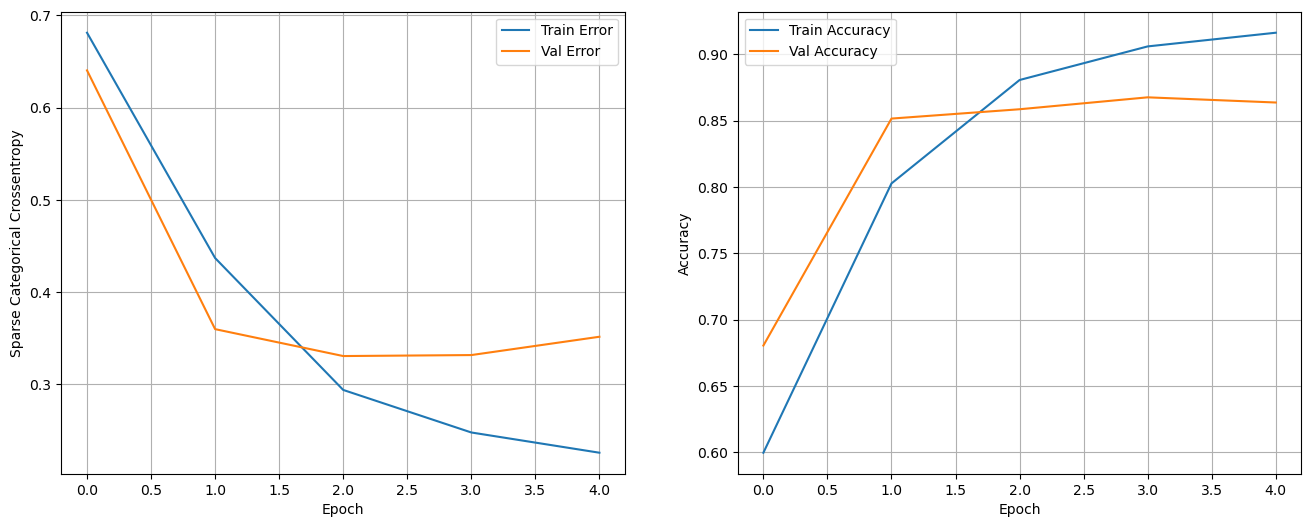

In [23]:
import pandas as pd
def show_loss_accuracy_evolution(history):
    
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Sparse Categorical Crossentropy')
    ax1.plot(hist['epoch'], hist['loss'], label='Train Error')
    ax1.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
    ax1.grid()
    ax1.legend()

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.plot(hist['epoch'], hist['accuracy'], label='Train Accuracy')
    ax2.plot(hist['epoch'], hist['val_accuracy'], label = 'Val Accuracy')
    ax2.grid()
    ax2.legend()

    plt.show()

show_loss_accuracy_evolution(history)

Run a prediction on a new sentence:

If the prediction is >= 0.5, it is positive else it is negative.

In [24]:
reviews = ['the film was really bad and i am very disappointed',
           'The film was very funny entertaining and good we had a great time . brilliant film',
           'this film was just brilliant',
          'This movie has been a disaster',
           'the movie is not bad']
predictions = model.predict(np.array(reviews))

for review, pred in zip(reviews, predictions.flatten()):
    print()
    print(review)
    print('Sentiment: ', np.round(pred, 2))

1/1 [==============================] - 0s 387ms/step

the film was really bad and i am very disappointed
Sentiment:  0.26

The film was very funny entertaining and good we had a great time . brilliant film
Sentiment:  0.96

this film was just brilliant
Sentiment:  0.59

This movie has been a disaster
Sentiment:  0.3

the movie is not bad
Sentiment:  0.19


### Question 1: Change the  `vocab_size`, `max_sequence_length` and embedding dimension too compare the results

In [25]:
vocab_size = 1000 # Number of words
max_sequence_length = 60#None# 100  # Max length of a sentence 
embedding_size = 128## embedding dimension

In [26]:
# Create a TextVectorization layer to preprocess the text
preprocessing = layers.experimental.preprocessing.TextVectorization(
    max_tokens=vocab_size, output_sequence_length=max_sequence_length)

# Adapt the TextVectorization layer to the training data
preprocessing.adapt(train_dataset.map(lambda text, label: text))

In [27]:

# Define the input layer for the text
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

# Preprocess the text using the TextVectorization layer
x = preprocessing(inputs)

# Define the embedding layer and apply it to the preprocessed text
x = tf.keras.layers.Embedding(
        input_dim=len(preprocessing.get_vocabulary()),
        output_dim=embedding_size,
        # Use masking to handle the variable sequence lengths
        mask_zero=True)(x)

x = tf.keras.layers.GRU(32)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Define the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

Epoch 1/10
49/49 [==============================] - 8s 138ms/step - loss: 0.6857 - accuracy: 0.5491 - val_loss: 0.6615 - val_accuracy: 0.6129
Epoch 2/10
49/49 [==============================] - 6s 120ms/step - loss: 0.5432 - accuracy: 0.7284 - val_loss: 0.5027 - val_accuracy: 0.7590
Epoch 3/10
49/49 [==============================] - 6s 126ms/step - loss: 0.4842 - accuracy: 0.7670 - val_loss: 0.4973 - val_accuracy: 0.7668
Epoch 4/10
49/49 [==============================] - 7s 133ms/step - loss: 0.4736 - accuracy: 0.7764 - val_loss: 0.4983 - val_accuracy: 0.7660
Epoch 5/10
49/49 [==============================] - 7s 143ms/step - loss: 0.4676 - accuracy: 0.7812 - val_loss: 0.4993 - val_accuracy: 0.7613
Epoch 6/10
49/49 [==============================] - 7s 142ms/step - loss: 0.4672 - accuracy: 0.7800 - val_loss: 0.4930 - val_accuracy: 0.7652
Epoch 7/10
49/49 [==============================] - 6s 123ms/step - loss: 0.4568 - accuracy: 0.7857 - val_loss: 0.4913 - val_accuracy: 0.7691
Epoch 

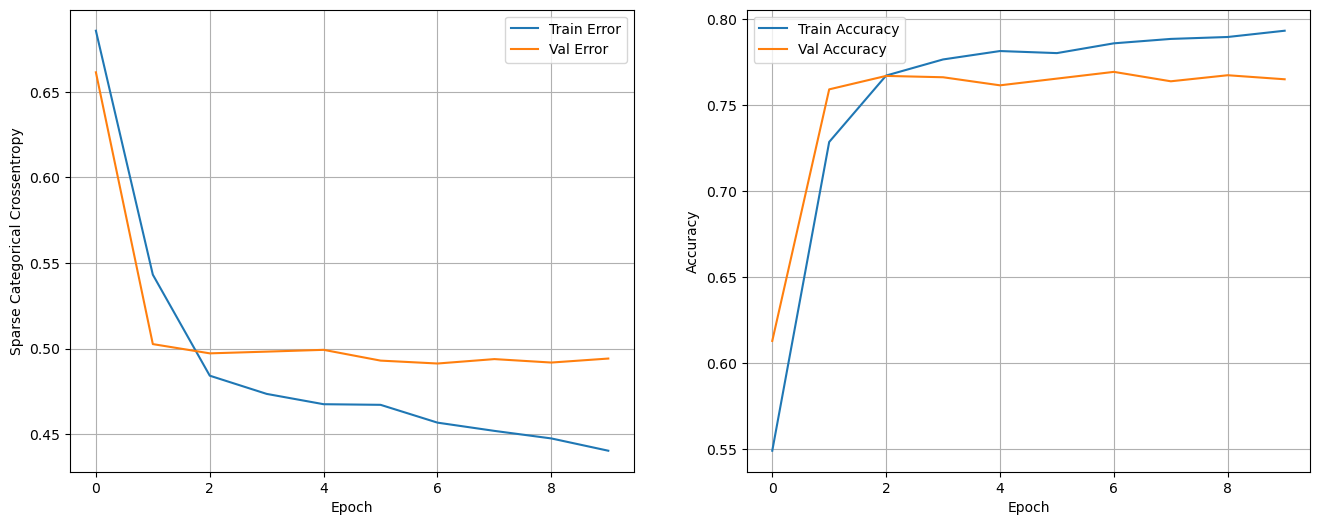

49/49 [==============================] - 3s 53ms/step - loss: 0.4993 - accuracy: 0.7546
Test Loss: 0.49933505058288574
Test Accuracy: 0.7545599937438965


In [28]:
model.compile(loss='BinaryCrossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=5)
show_loss_accuracy_evolution(history)

results = model.evaluate(test_dataset)

print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

In [29]:
reviews = ['the film was really bad and i am very disappointed',
           'The film was very funny entertaining and good we had a great time . brilliant film',
           'this film was just brilliant',
          'This movie has been a disaster', 'the movie is not bad']
predictions = model.predict(np.array(reviews))

for review, pred in zip(reviews, predictions.flatten()):
    print()
    print(review)
    print('Sentiment: ', np.round(pred, 2))

1/1 [==============================] - 0s 359ms/step

the film was really bad and i am very disappointed
Sentiment:  0.2

The film was very funny entertaining and good we had a great time . brilliant film
Sentiment:  0.92

this film was just brilliant
Sentiment:  0.76

This movie has been a disaster
Sentiment:  0.49

the movie is not bad
Sentiment:  0.2


### Question 2: Use a convolutional   network instead of a RNN

```python
tf.keras.layers.Conv1D(
    filters, kernel_size
)
```

```python
tf.keras.layers.MaxPool1D(
    pool_size=2
)
```

```python
tf.keras.layers.Flatten()
```

In [30]:
vocab_size = 5000 # Number of words
max_sequence_length = 600#None# 100  # Max length of a sentence 
embedding_size = 300## embedding dimension

In [31]:
preprocessing = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=vocab_size, output_sequence_length=max_sequence_length)
preprocessing.adapt(train_dataset.map(lambda text, label: text))


In [33]:
# Define the input layer for the text
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

# Preprocess the text using the TextVectorization layer
x = preprocessing(inputs)

# Define the embedding layer and apply it to the preprocessed text
x = tf.keras.layers.Embedding(
        input_dim=len(preprocessing.get_vocabulary()),
        output_dim=embedding_size,
        # Use masking to handle the variable sequence lengths
        mask_zero=True)(x)


x = layers.Conv1D(32, 3, activation='relu')(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(32, 3, activation='relu')(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Flatten()(x)



outputs = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

Epoch 1/5
49/49 [==============================] - 24s 486ms/step - loss: 0.6557 - accuracy: 0.5965 - val_loss: 0.4846 - val_accuracy: 0.7805
Epoch 2/5
49/49 [==============================] - 23s 463ms/step - loss: 0.3268 - accuracy: 0.8658 - val_loss: 0.2984 - val_accuracy: 0.8707
Epoch 3/5
49/49 [==============================] - 23s 464ms/step - loss: 0.2142 - accuracy: 0.9186 - val_loss: 0.3104 - val_accuracy: 0.8723
Epoch 4/5
49/49 [==============================] - 23s 469ms/step - loss: 0.1781 - accuracy: 0.9318 - val_loss: 0.3314 - val_accuracy: 0.8727
Epoch 5/5
49/49 [==============================] - 23s 463ms/step - loss: 0.1472 - accuracy: 0.9465 - val_loss: 0.3610 - val_accuracy: 0.8695


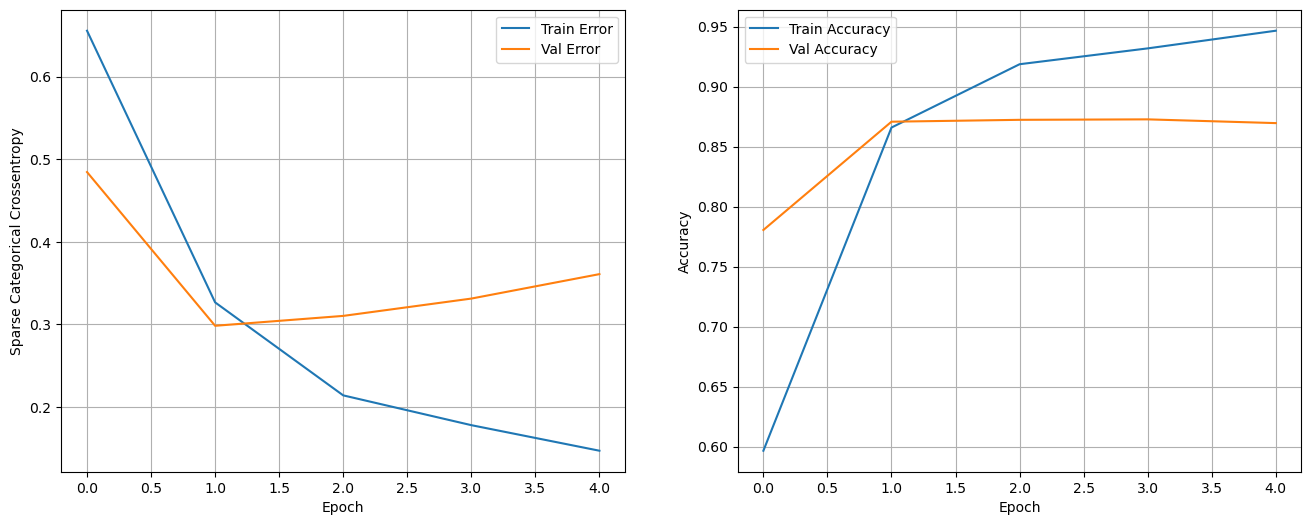

49/49 [==============================] - 6s 130ms/step - loss: 0.3607 - accuracy: 0.8682
Test Loss: 0.36065784096717834
Test Accuracy: 0.8682000041007996


In [34]:
model.compile(loss='BinaryCrossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history = model.fit(train_dataset, epochs=5,
                    validation_data=test_dataset, 
                    validation_steps=5)
show_loss_accuracy_evolution(history)

results = model.evaluate(test_dataset)

print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

In [35]:
reviews = ['the film was really bad and i am very disappointed',
           'The film was very funny entertaining and good we had a great time . brilliant film',
           'this film was just brilliant',
           'This movie has been a disaster',
           'very good',
           'film very good',
           'the film is very good',
           'the film is not good',
           'the film is not very good',
           'the movie is not bad',
           'the movie is not very bad']
predictions = model.predict(np.array(reviews))

for review, pred in zip(reviews, predictions.flatten()):
    print()
    print(review)
    print('Sentiment: ', np.round(pred, 2))

1/1 [==============================] - 0s 45ms/step

the film was really bad and i am very disappointed
Sentiment:  0.16

The film was very funny entertaining and good we had a great time . brilliant film
Sentiment:  0.96

this film was just brilliant
Sentiment:  0.85

This movie has been a disaster
Sentiment:  0.49

very good
Sentiment:  0.73

film very good
Sentiment:  0.74

the film is very good
Sentiment:  0.8

the film is not good
Sentiment:  0.68

the film is not very good
Sentiment:  0.74

the movie is not bad
Sentiment:  0.4

the movie is not very bad
Sentiment:  0.36


## Generalization

We are going to see, how the trained model generalizes in a new dataset.

Large Yelp Review Dataset. This is a dataset for binary sentiment classification. We provide a set of 560,000 highly polar yelp reviews for training, and 38,000 for testing. ORIGIN The Yelp reviews dataset consists of reviews from Yelp. It is extracted from the Yelp Dataset Challenge 2015 data. For more information, please refer to http://www.yelp.com/dataset



In [36]:
dataset_yelp, info = tfds.load('yelp_polarity_reviews', with_info=True,
                          as_supervised=True)
train_dataset_yelp, test_dataset_yelp = dataset_yelp['train'], dataset_yelp['test']

train_dataset_yelp.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [37]:
for example, label in test_dataset_yelp.take(2):
    print('text: ', example.numpy())
    print('label: ', label.numpy())

text:  b'Was not impressed, and will not return.'
label:  0
text:  b'I went in to purchase overalls and was treated so rudely I had to walk out even though he had the item I wanted.  I will never step foot in this placec of business again.'
label:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [38]:
BUFFER_SIZE = 10000
BATCH_SIZE = 128
train_dataset_yelp = train_dataset_yelp.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset_yelp = test_dataset_yelp.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [39]:
for example, label in test_dataset_yelp.take(1):
    print('text: ', example.numpy()[0])
    print('label: ', label.numpy()[0])

text:  b'Was not impressed, and will not return.'
label:  0


### Generalization of the IMBD-model

In [40]:
results = model.evaluate(test_dataset_yelp)

print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

297/297 [==============================] - 9s 32ms/step - loss: 0.5059 - accuracy: 0.7818
Test Loss: 0.5058591961860657
Test Accuracy: 0.7818421125411987


### Question 3: Create a model for the Yelp dataset and obtain `val_accuracy>0.92`

In [41]:
embedding_size = 200
max_sequence_length = 150
vocab_size = 9000
preprocessing_yelp = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=vocab_size, output_sequence_length=max_sequence_length)
preprocessing_yelp.adapt(train_dataset_yelp.map(lambda text, label: text))

In [42]:
# Define the input layer for the text
inputs = layers.Input(shape=(1,), dtype=tf.string)

# Preprocess the text using the TextVectorization layer
x = preprocessing_yelp(inputs)

# Define the embedding layer and apply it to the preprocessed text
x = layers.Embedding(
        input_dim=len(preprocessing_yelp.get_vocabulary()),
        output_dim=embedding_size,
        # Use masking to handle the variable sequence lengths
        mask_zero=True)(x)

x = tf.keras.layers.GRU(32)(x)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)


model_yelp = tf.keras.Model(inputs=inputs, outputs=outputs)

4375/4375 [==============================] - 425s 97ms/step - loss: 0.2050 - accuracy: 0.9179 - val_loss: 0.1415 - val_accuracy: 0.9500


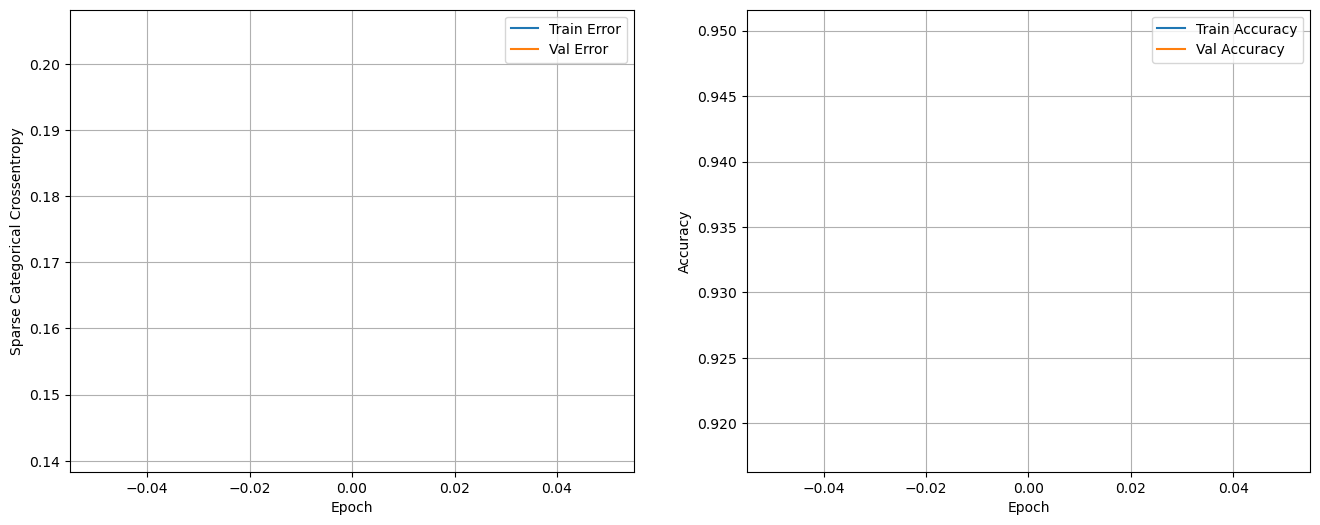

297/297 [==============================] - 8s 25ms/step - loss: 0.1540 - accuracy: 0.9404
Test Loss: 0.15395206212997437
Test Accuracy: 0.9403684139251709


In [43]:
model_yelp.compile(loss='BinaryCrossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model_yelp.fit(train_dataset_yelp, epochs=1,
                    validation_data=test_dataset_yelp, 
                    validation_steps=10)
show_loss_accuracy_evolution(history)

results = model_yelp.evaluate(test_dataset_yelp)

print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

In [44]:
reviews = ['the film was really bad and i am very disappointed',
           'The film was very funny entertaining and good we had a great time . brilliant film',
           'this film was just brilliant',
          'This movie has been a disaster',
          'very good',
           'the film isn\'t very good',
           'the film is very good',
           'the movie is not bad',
           'the film is not good',
           'the movie is  bad']
predictions = model_yelp.predict(np.array(reviews))

for review, pred in zip(reviews, predictions.flatten()):
    print()
    print(review)
    print('Sentiment: ', np.round(pred, 2))

1/1 [==============================] - 0s 337ms/step

the film was really bad and i am very disappointed
Sentiment:  0.01

The film was very funny entertaining and good we had a great time . brilliant film
Sentiment:  0.99

this film was just brilliant
Sentiment:  0.84

This movie has been a disaster
Sentiment:  0.09

very good
Sentiment:  0.92

the film isn't very good
Sentiment:  0.28

the film is very good
Sentiment:  0.93

the movie is not bad
Sentiment:  0.61

the film is not good
Sentiment:  0.12

the movie is  bad
Sentiment:  0.18


In [45]:
results = model_yelp.evaluate(test_dataset_yelp)

print('Yelp-model in Yelp dataset Test Loss: {}'.format(results[0]))
print('Yelp-model in Yelp dataset Test Accuracy: {}'.format(results[1]))
print('--'*50)

results = model.evaluate(test_dataset_yelp)

print('IMBD-model in Yelp dataset Test Loss: {}'.format(results[0]))
print('IMBD-model in Yelp dataset Test Accuracy: {}'.format(results[1]))

297/297 [==============================] - 8s 26ms/step - loss: 0.1540 - accuracy: 0.9404
Yelp-model in Yelp dataset Test Loss: 0.15395206212997437
Yelp-model in Yelp dataset Test Accuracy: 0.9403684139251709
----------------------------------------------------------------------------------------------------
297/297 [==============================] - 9s 29ms/step - loss: 0.5059 - accuracy: 0.7818
IMBD-model in Yelp dataset Test Loss: 0.5058591961860657
IMBD-model in Yelp dataset Test Accuracy: 0.7818421125411987


In [46]:
results = model_yelp.evaluate(test_dataset)

print('Yelp-model in IMBD dataset Test Loss: {}'.format(results[0]))
print('Yelp-model in IMBD dataset Test Accuracy: {}'.format(results[1]))
print('--'*50)

results = model.evaluate(test_dataset)

print('IMBD-model in IMBD dataset Test Loss: {}'.format(results[0]))
print('IMBD-model in IMBD dataset Test Accuracy: {}'.format(results[1]))

49/49 [==============================] - 4s 88ms/step - loss: 0.3994 - accuracy: 0.8150
Yelp-model in IMBD dataset Test Loss: 0.39942067861557007
Yelp-model in IMBD dataset Test Accuracy: 0.8150399923324585
----------------------------------------------------------------------------------------------------
49/49 [==============================] - 6s 116ms/step - loss: 0.3607 - accuracy: 0.8682
IMBD-model in IMBD dataset Test Loss: 0.36065784096717834
IMBD-model in IMBD dataset Test Accuracy: 0.8682000041007996


### Train the pretrained Yelp model in the IMBD dataset

49/49 [==============================] - 16s 321ms/step - loss: 0.3763 - accuracy: 0.8262 - val_loss: 0.3427 - val_accuracy: 0.8474


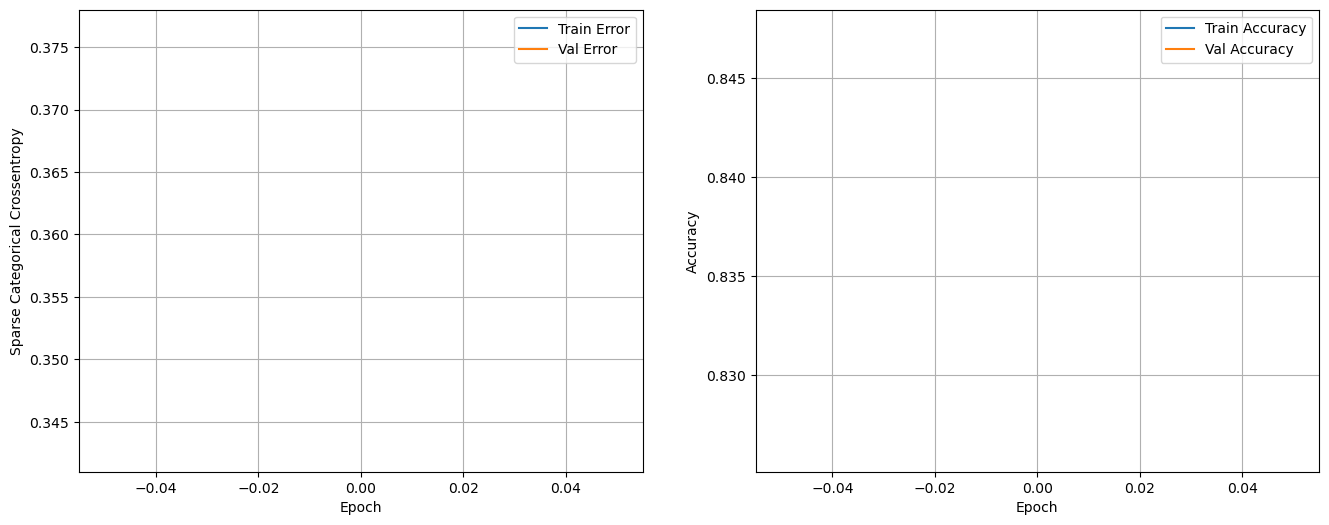

49/49 [==============================] - 5s 96ms/step - loss: 0.3398 - accuracy: 0.8485
Test Loss: 0.3397988975048065
Test Accuracy: 0.8485199809074402


In [47]:
history = model_yelp.fit(train_dataset, epochs=1,
                    validation_data=test_dataset, 
                    validation_steps=15)
show_loss_accuracy_evolution(history)

results = model_yelp.evaluate(test_dataset)

print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

## Extra
### Transfer learning: pre-trained text embeddings

For this example we will use a **pre-trained text embedding model** from [TensorFlow Hub](https://tfhub.dev) called [google/nnlm-en-dim128/2](https://tfhub.dev/google/nnlm-en-dim128/2).

[TensorFlow Hub](https://tfhub.dev/) has hundreds of trained, ready-to-deploy machine learning models.  You can find more [text embedding models](https://tfhub.dev/s?module-type=text-embedding) on TFHub.

One way to represent the text is to convert sentences into embeddings vectors. We can use a pre-trained text embedding as the first layer, which will have three advantages:

One way to represent the text is to convert sentences into embeddings vectors. We can use a pre-trained text embedding as the first layer, which will have three advantages:

*   we don't have to worry about text preprocessing,
*   we can benefit from transfer learning,
*   the embedding has a fixed size, so it's simpler to process.

For this example we will use a pre-trained text embedding model from TensorFlow Hub called google/nnlm-en-dim128/2.
Let's first create a Keras layer that uses a TensorFlow Hub model to embed the sentences.

In [ ]:
!pip install tensorflow-hub

In [ ]:
import tensorflow_hub as hub

embedding = "https://tfhub.dev/google/nnlm-en-dim128/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)

In [ ]:
hub_layer(['The film was ok'])

In [ ]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

In [ ]:
model.compile(loss='BinaryCrossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history = model.fit(train_dataset, epochs=2,
                    validation_data=test_dataset, 
                    validation_steps=15)
show_loss_accuracy_evolution(history)

In [ ]:
results = model.evaluate(test_dataset)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))